In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, MaxPool1D, Embedding, GlobalMaxPool1D, Conv1D
from keras.models import Model
from sklearn.metrics import roc_auc_score

In [2]:
# some configuration
MAX_SEQUENCE_LENGTH = 300
MAX_VOCAB_SIZE = 20000
EMBEDDING_DIM = 100
VALIDATION_SPLIT = 0.2
BATCH_SIZE = 128
EPOCHS = 10

In [3]:
print("loading pretrained vectors...")
word2vec ={}
with open('glove.6B.100d.txt',encoding="utf-8") as f:
    # is just a space-seperated text file in the format:
    # word vec[0] vec[1] vec[2]...
    for line in f:
        values = line.split()
        word = values[0]
        vec = np.asarray(values[1:], dtype ="float32")
        word2vec[word] = vec
    print("Found %s word vectors." % len(word2vec))

loading pretrained vectors...
Found 400000 word vectors.


In [4]:
print('loading in comments...')

loading in comments...


In [5]:
train = pd.read_csv("toxic_comment_train.csv")

In [6]:
sentences = train["comment_text"].fillna("DUMMY_VALUE").values

In [7]:
possible_labels = train.columns[2:]

In [8]:
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [9]:
train.shape

(159571, 8)

In [10]:
targets = train[possible_labels].values

In [11]:
# convert the sentences (strings) into integers
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
tokenizer.fit_on_texts(sentences)
sequences = tokenizer.texts_to_sequences(sentences)

In [12]:
print("max sequence length:", max(len(s) for s in sequences)) 
print("min sequence length:", min(len(s) for s in sequences))
s = sorted(len(s) for s in sequences)
print("median sequence length:", s[len(s)//2])

print("max word index:", max(max(seq) for seq in sequences if len(seq) >0 ))

max sequence length: 1400
min sequence length: 0
median sequence length: 35
max word index: 19999


In [13]:
word2idx = tokenizer.index_word
print(f"Found {len(word2idx)} unique tokens")

Found 210337 unique tokens


In [14]:
data = pad_sequences(sequences,maxlen=MAX_SEQUENCE_LENGTH)
print("Shape of data tensor:",data.shape)

Shape of data tensor: (159571, 300)


In [15]:
print("Filling pre-trained embeddings..")
num_words = min(MAX_VOCAB_SIZE,len(word2idx) + 1)
embedding_matrix = np.zeros((num_words,EMBEDDING_DIM))
for i,word in word2idx.items():
    if i < MAX_VOCAB_SIZE:
        embedding_vector = word2vec.get(word)
        if embedding_vector is not None:
            # words not found in embedding index will be all zeros.
            embedding_matrix[i] = embedding_vector

Filling pre-trained embeddings..


In [16]:
# load pre-trained word embeddings into an Embedding layer
# note that we set trainable = False so as to keep the embeddings fixed
embedding_layer = Embedding(
    num_words,
    EMBEDDING_DIM,
    weights = [embedding_matrix],
    input_length = MAX_SEQUENCE_LENGTH,
    trainable = False)

In [17]:
print("Building model...")

# train a 1D covnet with global maxpooling
input_ = Input(shape=(MAX_SEQUENCE_LENGTH,))
x = embedding_layer(input_)
x = Conv1D(128, 3, activation='relu')(x)
x = MaxPool1D(3)(x)
x = Conv1D(128,3,activation="relu")(x)
x = MaxPool1D(3)(x)
x = Conv1D(128, 3, activation='relu')(x)
x = GlobalMaxPool1D()(x)
x = Dense(128, activation='relu')(x)
output = Dense(len(possible_labels), activation='sigmoid')(x)

Building model...



In [18]:
model = Model(input_, output)
model.compile(loss='binary_crossentropy',optimizer='rmsprop',metrics=['accuracy'])
print('Training model...')
r = model.fit(
    data, targets,batch_size=BATCH_SIZE,epochs=EPOCHS,
    validation_split=VALIDATION_SPLIT
    )


Training model...
Epoch 1/10


998/998 [==============================] - 77s 76ms/step - loss: 0.0912 - accuracy: 0.9821 - val_loss: 0.0776 - val_accuracy: 0.9941
Epoch 2/10
998/998 [==============================] - 81s 81ms/step - loss: 0.0735 - accuracy: 0.9940 - val_loss: 0.0743 - val_accuracy: 0.9922
Epoch 3/10
998/998 [==============================] - 81s 81ms/step - loss: 0.0689 - accuracy: 0.9931 - val_loss: 0.0715 - val_accuracy: 0.9940
Epoch 4/10
998/998 [==============================] - 83s 83ms/step - loss: 0.0656 - accuracy: 0.9930 - val_loss: 0.0729 - val_accuracy: 0.9941
Epoch 5/10
998/998 [==============================] - 84s 85ms/step - loss: 0.0623 - accuracy: 0.9928 - val_loss: 0.0726 - val_accuracy: 0.9940
Epoch 6/10
998/998 [==============================] - 80s 80ms/step - loss: 0.0594 - accuracy: 0.9933 - val_loss: 0.0785 - val_accuracy: 0.9938
Epoch 7/10
998/998 [==============================] - 1334s 1s/step - loss: 0.0563 - accuracy: 0.9933 - val_loss: 0

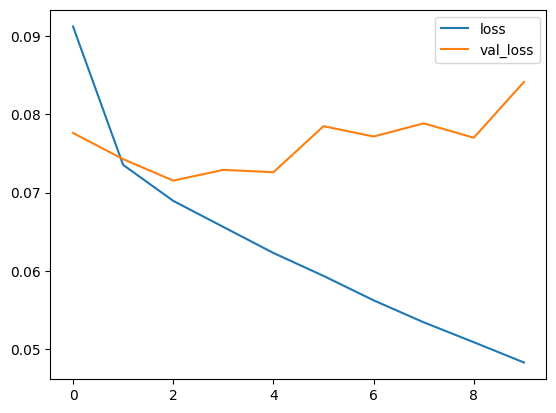

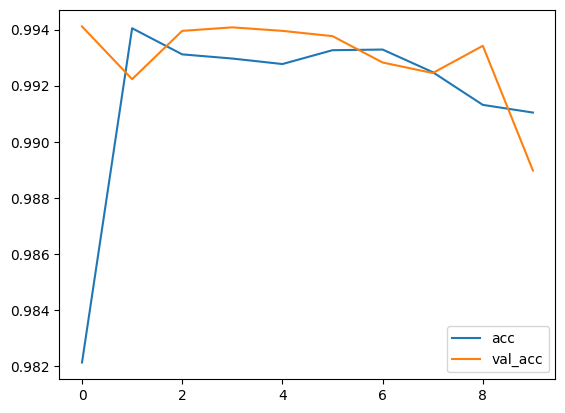

In [19]:
# plot some data
plt.plot(r.history['loss'], label ='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

# accuracies
plt.plot(r.history['accuracy'], label='acc')
plt.plot(r.history['val_accuracy'], label='val_acc')
plt.legend()
plt.show()

In [20]:
p = model.predict(data)

4987/4987 [==============================] - 1627s 326ms/step


In [29]:
# plot the mean AUC over each label
aucs = []
for j in range(6):
    auc = roc_auc_score(targets[:,j],p[:,j])
    aucs.append(auc)
print(np.mean(aucs))

0.9771452289015162
